In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Helper functions

# Show as inline with matplotlib (avoids cv2.imshow issues)
def show(img, title="image", cmap='gray'):
    plt.figure(figsize=(4, 4))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        # convert BGR -> RGB for correct colors
        img_rgb = cv2.cvtColor(img, cv.COLOR_BGR2RGB)        
        plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

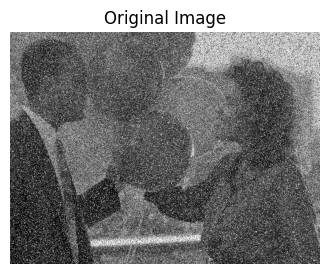

In [3]:
# Example image
img_path = r'D:/Python things/middle-ml-cv-roadmap/data/raw/img_example_3_noisy_foreground.jpg'
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
# img = cv.imread(img_path)
show(img, 'Original Image')

### Filters: Smoothing/Blurring

An **image filter** is a tool that modifies an image by altering the pixel values to achieve a specific effect, such as sharpening, smoothing, or detecting edges.

**How They Work: Convolution and Kernels**
- Most filters are implemented using a mathematical operation called convolution.
- Convolution involves using a small matrix, called a kernel, filter mask, or convolution matrix, which is slid over every pixel of the original image.
- At each pixel, the kernel's values are multiplied element-by-element with the corresponding pixel values in the image neighborhood, and the results are summed up. This sum becomes the new value for the center pixel in the output image.
- The values within the kernel determine the effect of the filter.

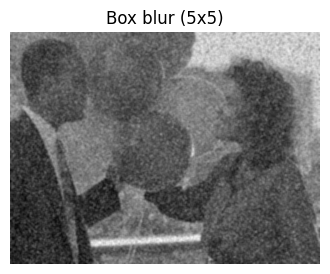

In [4]:
# Average (box) blur
'''
Each pixel becomes the mean of its neighbors.
Larger kernel ⇒ stronger blur, more detail lost.
Good for simple smoothing, noise reduction, but edges become very “washed out”.
'''
blur = cv.blur(img, ksize=(5, 5))
show(blur, 'Box blur (5x5)')

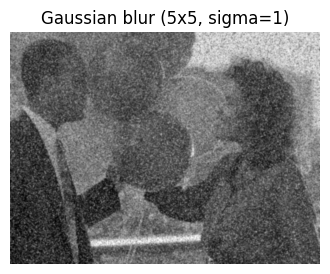

In [5]:
# Gaussian blur
'''
Kernel weights follow a Gaussian (normal) distribution: center has highest weight, neighbors less. This preserves edges better than simple averaging.
ksize must be odd: (3,3), (5,5), etc.
sigmaX – standard deviation of Gaussian; if 0, OpenCV chooses it based on ksize.
Often used as pre-processing step before edge detection (Canny).
'''
gauss = cv.GaussianBlur(img, ksize=(5, 5), sigmaX=1)
show(gauss, "Gaussian blur (5x5, sigma=week_1)")

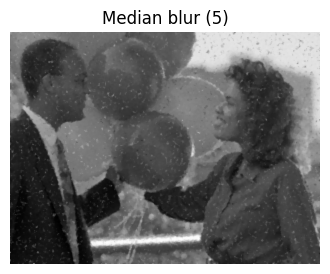

In [6]:
# Median blur
'''
Each pixel becomes the median of its neighborhood — great for “salt-and-pepper” noise.
ksize must be odd number: 3, 5, 7, etc.
'''
median = cv.medianBlur(img, ksize=5)
show(median, "Median blur (5)")

### Filters: Sharpening/Edge Detection

Edge = place where intensity changes sharply → high gradient.

These filters emphasize the high spatial-frequency components, making details and edges stand out.

**Sharpening** aims to make an image look clearer and more defined by **enhancing the contrast** along existing edges and details. The goal is a more visually pleasing, "crisper" image for human viewing.

**Edge detection** is a fundamental step in computer vision used to identify the curves in an image where the brightness or color changes sharply, typically marking the **boundaries of objects**. The output is usually an image where only the edges are visible.

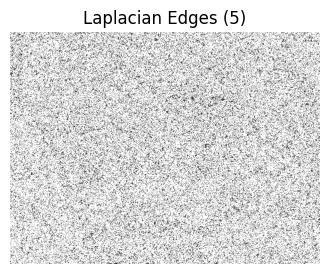

In [7]:
# Laplacian Filter (Sharpening)
'''
Works by amplifying the difference in pixel values between a pixel and its neighbors.
ddepth: desired depth of the destination image (e.g., cv2.CV_64F for float output).
# ksize: size of the kernel (must be odd, e.g., 3, 5, 7)
Gaussian blur to reduce noise is optional, but recommended for Laplacian filter. 
'''
gauss = cv.GaussianBlur(img, ksize=(5, 5), sigmaX=1)
laplacian = cv.Laplacian(gauss, cv.CV_64F, ksize=5)
laplacian_8bit = cv.convertScaleAbs(laplacian)  # Convert back to 8-bit for display (if ddepth was not 8-bit)
show(laplacian_8bit, 'Laplacian Edges (5)')

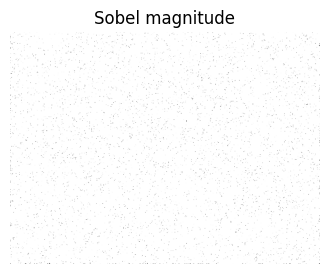

In [8]:
# Sobel operator (Edge Detection)
'''
Sobel approximates derivative in x and y directions.
ddepth=cv2.CV_64F – to avoid overflow when computing derivatives.
dx, dy determine direction: (week_1,0) → x, (0,week_1) → y.
ksize (week_1,3,5…) – kernel size, larger = smoother but less precise edges (must be odd).
'''
# Sobel in x-direction
sobelx = cv.Sobel(img, ddepth=cv.CV_64F, dx=1, dy=0, ksize=5)
# Sobel in y-direction
sobely = cv.Sobel(img, ddepth=cv.CV_64F, dx=0, dy=1, ksize=5)

# gradient magnitude
sobel_mag = np.sqrt(sobelx**2 + sobely**2)
sobel_mag = np.uint8(np.clip(sobel_mag, 0, 255))

show(sobel_mag, "Sobel magnitude")

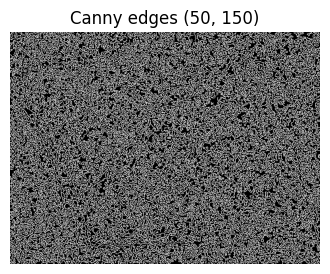

In [9]:
# Canny edge detector
'''
Canny is a multi-stage edge detector:
week_1. Gaussian blur (reduce noise).
2. Gradient computation (like Sobel).
3. Non-maximum suppression (thin edges).
4. Double threshold + hysteresis (connects weak edges touching strong ones).
threshold1 = lower threshold, threshold2 = upper.
Strong edges > threshold2; weak edges between the two are kept only if connected to strong ones.
Thresholds tune experimentally.
'''
blurred = cv.GaussianBlur(img, (5, 5), 1.0)
edges = cv.Canny(blurred, threshold1=50, threshold2=150)
show(edges, "Canny edges (50, 150)")

### Thresholding

**Thresholding** is a method used to create a **binary image** from a **grayscale image**.

The process revolves around a single number: the **threshold value** ($T$).
1. We pick a value for $T$ (usually between 0 and 255).
2. We look at every single pixel in the original grayscale image.
3. If a pixel's intensity value is greater than $T$, we set that pixel to white (or 255).
4. If a pixel's intensity value is less than or equal to $T$, we set that pixel to black (or 0).

Goals: **Simplifies the Image**, **Isolates Objects/Segmentation**, **Prepares for Further Processing**.

Types: **Simple (Global)**, **Adaptive (Local)**, **Otsu's Binarization**.

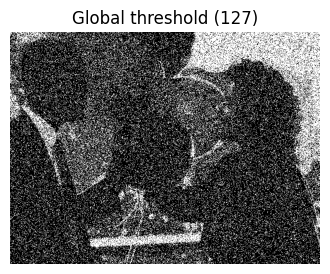

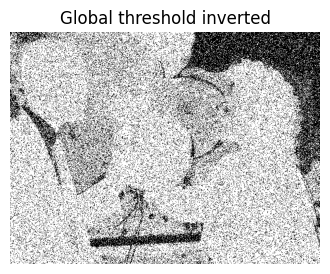

In [10]:
# Global threshold
'''
Main types (type argument):
- cv2.THRESH_BINARY
- cv2.THRESH_BINARY_INV
- cv2.THRESH_TRUNC (values above T set to T)
- cv2.THRESH_TOZERO / TOZERO_INV
'''
# T = 127, max value = 255
ret, th_bin = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
show(th_bin, "Global threshold (127)")

# inverted:
ret, th_inv = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
show(th_inv, "Global threshold inverted")

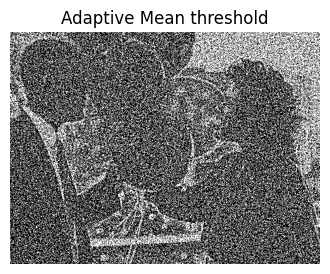

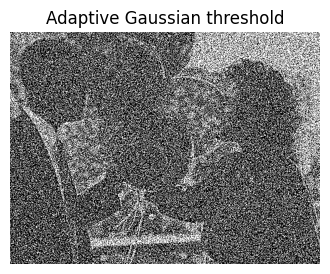

In [11]:
# Adaptive thresholding
'''
blockSize = size of neighborhood; must be odd
C = constant subtracted from mean/weighted mean
'''
th_mean = cv.adaptiveThreshold(
    img, 255,
    cv.ADAPTIVE_THRESH_MEAN_C,
    cv.THRESH_BINARY,
    blockSize=11,
    C=2)
show(th_mean, "Adaptive Mean threshold")

th_gauss = cv.adaptiveThreshold(
    img, 255,
    cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv.THRESH_BINARY,
    blockSize=11,
    C=2)
show(th_gauss, "Adaptive Gaussian threshold")

Otsu threshold: 116.0


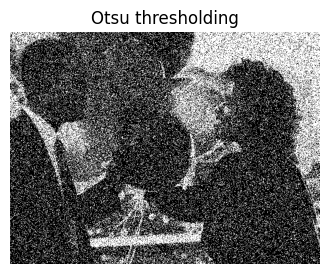

In [12]:
# Otsu’s thresholding
'''
Good when lighting is relatively uniform but you don’t know threshold.
'''
ret, th_otsu = cv.threshold(
    img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
print("Otsu threshold:", ret)
show(th_otsu, "Otsu thresholding")

### Morphological operations: erode, dilate, open, close

**Morphological Operations** let manipulate the **shape and structure** of objects in an image.

They are typically applied to **binary images** (pure black and white), and all of them rely on a small kernel, called a **Structuring Element** (SE). This SE defines the neighborhood of pixels you are examining.

In [13]:
# Structuring element (kernel)
kernel = np.ones((3, 3), np.uint8)   # simple 3x3 square
# or more advanced:
kernel_rect = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
kernel_ellipse = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

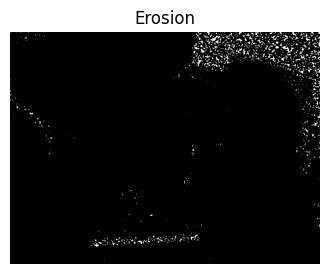

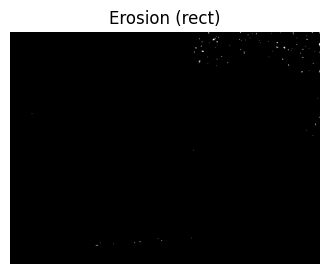

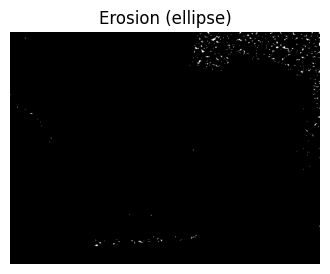

In [14]:
# Erosion
'''
Erosion shrinks foreground objects, remove small specks of noise ("salt" noise), and break apart objects that are barely touching.
Mechanism: 
- SE slides over the image. 
- A pixel in the output image is set to white (foreground) only if ALL the pixels in its neighborhood (defined by the SE)
    in the input image are also white. 
- If even one pixel under the SE is black (background), the center pixel turns black.
'''
eroded = cv.erode(th_bin, kernel, iterations=1)
eroded_rect = cv.erode(th_bin, kernel_rect, iterations=1)
eroded_ellipse = cv.erode(th_bin, kernel_ellipse, iterations=1)

show(eroded, "Erosion")
show(eroded_rect, "Erosion (rect)")
show(eroded_ellipse, "Erosion (ellipse)")

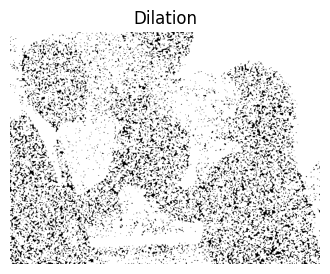

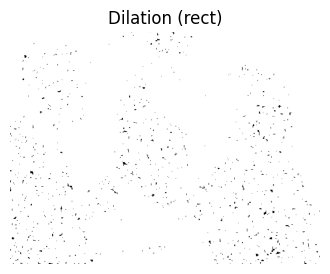

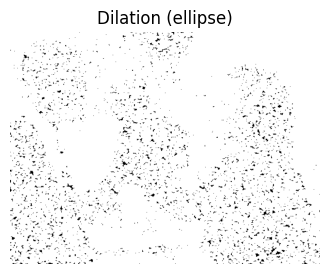

In [15]:
# Dilation
'''
Dilation expands foreground objects, fill in small holes/gaps inside an object ("pepper" noise), and connect nearby objects.
Mechanism: 
- The Structuring Element (SE) slides over the image. 
- A pixel in the output image is set to white (foreground) if AT LEAST ONE of the pixels in its neighborhood (defined by the SE) 
    in the input image is white.
'''
dilated = cv.dilate(th_bin, kernel, iterations=1)
dilated_rect = cv.dilate(th_bin, kernel_rect, iterations=1)
dilated_ellipse = cv.dilate(th_bin, kernel_ellipse, iterations=1)

show(dilated, "Dilation")
show(dilated_rect, "Dilation (rect)")
show(dilated_ellipse, "Dilation (ellipse)")

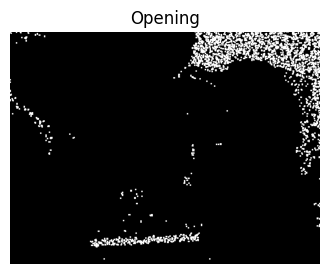

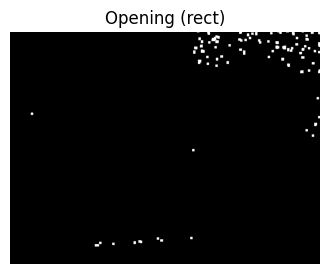

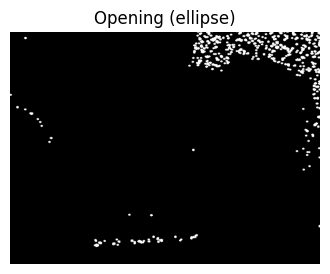

In [16]:
# Opening (erode → dilate)
'''
Opening (Erosion followed by Dilation) is primarily when:
- there are small isolated white dots.
- You want to clean up foreground.
'''
opened = cv.morphologyEx(th_bin, cv.MORPH_OPEN, kernel)
opened_rect = cv.morphologyEx(th_bin, cv.MORPH_OPEN, kernel_rect)
opened_ellipse = cv.morphologyEx(th_bin, cv.MORPH_OPEN, kernel_ellipse)

show(opened, "Opening")
show(opened_rect, "Opening (rect)")
show(opened_ellipse, "Opening (ellipse)")

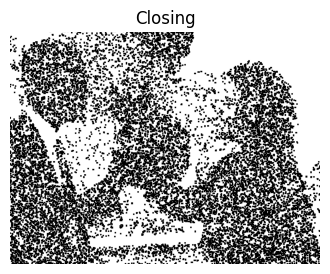

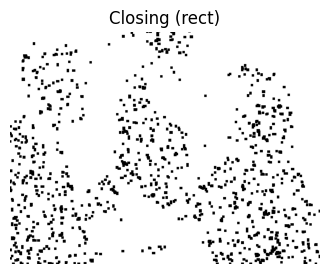

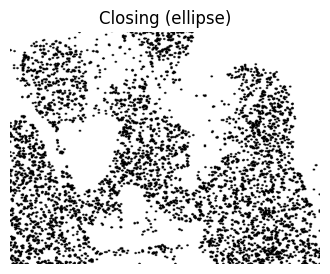

In [17]:
# Closing (dilate → erode)
'''
Closing (Dilation followed by Erosion) is primarily used when:
- Foreground has gaps, small black holes.
- You want continuous shapes.
'''
closed = cv.morphologyEx(th_bin, cv.MORPH_CLOSE, kernel)
closed_rect = cv.morphologyEx(th_bin, cv.MORPH_CLOSE, kernel_rect)
closed_ellipse = cv.morphologyEx(th_bin, cv.MORPH_CLOSE, kernel_ellipse)

show(closed, "Closing")
show(closed_rect, "Closing (rect)")
show(closed_ellipse, "Closing (ellipse)")